In [160]:
# Replace outliers with mean values and concatenate

import scipy.io
import numpy as np
import pandas as pd

# Load the time-series data (.mat files)
soc1 = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/SocStroop1_ts.mat')
soc2 = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/SocStroop2_ts.mat')
stop = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/StopSignal_ts.mat')
nback = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/NBack_ts.mat')

# Access the struct containing an array of cells
soc1 = soc1['roi_ts']
soc2 = soc2['roi_ts']
stop = stop['roi_ts']
nback = nback['roi_ts']

# Load outliers (.mat files)
soc1_outs = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/outliers/stroop1_outliers.mat')
soc2_outs = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/outliers/stroop2_outliers.mat')
stop_outs = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/outliers/stopsignal_outliers.mat')
nback_outs = scipy.io.loadmat('/home/adam/Desktop/projects/unitary/pipeline_2023/data/outliers/nback_outliers.mat')

# Access the struct containing an array of cells
soc1_outs = soc1_outs['outliers']
soc2_outs = soc2_outs['outliers']
stop_outs = stop_outs['outliers']
nback_outs = nback_outs['outliers']

# Replace outlier frames with mean of time-series

for sub in range(0,75):
    # soc1
    outlier_frames = np.where(soc1_outs[0,sub]==1)[0]
    if len(outlier_frames) > 0:
        for frame in outlier_frames:
            for roi in range(0,414):
                soc1[0,sub][frame,roi] = soc1[0,sub][:,roi].mean()

    # soc2
    outlier_frames = np.where(soc2_outs[0,sub]==1)[0]
    if len(outlier_frames) > 0:
        for frame in outlier_frames:
            for roi in range(0,414):
                soc2[0,sub][frame,roi] = soc2[0,sub][:,roi].mean()

for sub in range(0,94):
    # nback
    outlier_frames = np.where(nback_outs[0,sub]==1)[0]
    if len(outlier_frames) > 0:
        for frame in outlier_frames:
            for roi in range(0,414):
                nback[0,sub][frame,roi] = nback[0,sub][:,roi].mean()

    # stop
    outlier_frames = np.where(stop_outs[0,sub]==1)[0]
    if len(outlier_frames) > 0:
        for frame in outlier_frames:
            for roi in range(0,414):
                stop[0,sub][frame,roi] = stop[0,sub][:,roi].mean()

print('Done replacing outlier frames with mean roi values')

# Remove unused subs for stop and nback
if len(stop[0]) == len(nback[0]) == 94:
    conversion = pd.read_csv('/home/adam/Desktop/projects/unitary/pipeline_2023/subs/94_2_75_convert.csv', 
                             dtype={'Subject': str}, header=None)
    stop = stop[0,conversion.iloc[:,1]==1]
    nback = nback[0,conversion.iloc[:,1]==1]

# Concatenate time-series data
all_concatenated = np.zeros((522, 414, 75))

if len(soc1[0]) == len(soc2[0]) == len(stop) == len(nback) == 75:
    for sub in range(0,75):
        all_concatenated[:,:,sub] = np.concatenate((soc1[0,sub], soc2[0,sub],
                                                   stop[sub], nback[sub]), axis=0)

print('Done concatenating time-series of all tasks!')
print(f'Final shape is {all_concatenated.shape}')

Done replacing outlier frames with mean roi values!
Done concatenating time-series of all tasks!
Final shape is (522, 414, 75)


In [192]:
from nilearn.connectome import ConnectivityMeasure
import nilearn
import warnings

warnings.filterwarnings("ignore")
for sub in range(0,75):
    temp = all_concatenated[:,:,sub]
    
    FC = ConnectivityMeasure(kind='correlation')
    FC = FC.fit_transform([temp])[0]

    id = str(sub+1).zfill(3)
    pd.DataFrame(FC).to_csv(f'/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/fc_results/Concatenated/new_csvs/sub{id}-All.csv',index=False)


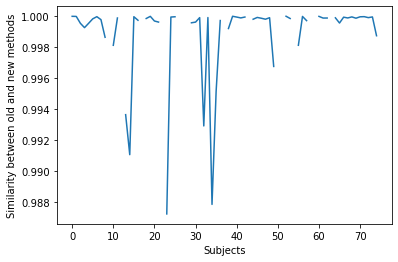

In [204]:
from matplotlib import pyplot as plt

base_dir = '/home/adam/Desktop/projects/unitary/pipeline_2023/data/Oliver_data/fc_results/Concatenated'
similarity = np.zeros((75))
for sub in range(0,75):
    id = str(sub+1).zfill(3)
    old = pd.read_csv(f'{base_dir}/csvs/sub{id}-All.csv',dtype={'Subject': str},header=None)
    old = old.values
    new = pd.read_csv(f'{base_dir}/new_csvs/sub{id}-All.csv',dtype={'Subject': str})
    new = new.values
    
    # Calculate the correlation coefficient between the two matrices
    correlation_matrix = np.corrcoef(old.flatten(), new.flatten())

    # The correlation coefficient is in the upper-left corner of the correlation matrix
    similarity[sub] = correlation_matrix[0, 1]

plt.plot(range(0,75), similarity)

# Add labels and title
plt.xlabel('Subjects')
plt.ylabel('Similarity between old and new methods')

# Show the graph
plt.show()